<a href="https://colab.research.google.com/github/blid11/Group9/blob/Brett/G9_PartC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Changes made in this Colab notebook can be saved with Control/Command S and do not need to be pushed to Github. 
Also apparently SVM is a better model for classifying than the PCA/neural network I was trying below.

In [1]:

# Import libaries needed
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

#print(os.getcwd())

# made a change in colab

In [2]:
from google.colab import drive 
drive.mount('/content/gdrive', force_remount=True)

%cd gdrive/My Drive/G9A2/G9
 
#%cd gdrive/My Drive/G9A2
# I made a folder on my google drive that has the G9 Methylation data and the binfpy library
#this code automatically loads it in
# you can do the same with your google drive. 
# restart runtime if you experience errors!

Mounted at /content/gdrive
/content/gdrive/My Drive/G9A2/G9


# Data Preparation


In [3]:
!ls

G9_liver_dna-meth.csv  G9_liver_gene-expr.csv


In [4]:
# load the data 
liver_meth_dna = pd.read_csv('G9_liver_dna-meth.csv')
liver_gene_expr = pd.read_csv('G9_liver_gene-expr.csv')


In [20]:
# view the data: 
liver_meth_dna.head(n = 5)
liver_gene_expr.shape

(421, 20533)

In [6]:
liver_gene_expr.head(n= 5)
#the first column is sample
#the second column is the Label 
# the third column onwards are Data (expression values for given gene)

,Unnamed: 0,Label,X..100130426,X..100133144,X..100134869,X..10357,X..10431,X..136542,X..155060,X..26823,...,ZXDA.7789,ZXDB.158586,ZXDC.79364,ZYG11A.440590,ZYG11B.79699,ZYX.7791,ZZEF1.23140,ZZZ3.26009,psiTPTE22.387590,tAKR.389932
0,TCGA.2V.A95S.01,Primary Tumor,0.0,1.5051,3.7074,90.1124,1017.1038,0.0,141.3911,0.6516,...,24.7597,273.6602,794.2662,18.2440,499.1041,3172.5037,890.0472,510.1808,3.9094,6.5157
1,TCGA.2Y.A9GS.01,Primary Tumor,0.0,26.4120,2.6663,71.0054,639.2311,0.0,122.7206,1.4786,...,68.5067,632.8241,1153.7703,71.4638,1000.4929,5301.1336,755.5446,860.5224,6.4071,482.9966
2,TCGA.2Y.A9GT.01,Primary Tumor,0.0,0.0000,4.4833,95.5122,742.4344,0.0,95.0460,1.7933,...,46.6263,1219.4575,1133.3782,12.5532,1289.3970,3219.0092,860.7935,523.6494,14.3466,83.3894
3,TCGA.2Y.A9GU.01,Primary Tumor,0.0,5.7222,5.1216,61.6679,1186.9807,0.0,280.2709,0.8341,...,18.3511,285.2758,1150.2786,9.1755,941.7437,3092.9899,1339.6283,343.6655,2.5024,2.5024
4,TCGA.2Y.A9GV.01,Primary Tumor,0.0,11.4975,5.4230,104.4670,878.1726,0.0,282.5719,0.0000,...,41.4552,999.1540,1631.9797,4.2301,1380.7107,2902.7073,575.2961,665.8206,2.5381,119.2893


will be creating two models: one for gene expression and one for methylation
so will not merge the two datasets 
we can use the same model architecture and train it on different data

standardizing and log transforming data relatively standard for gene expression data
and probably for methylation data as well 




In [7]:
# standardizing and log transform data prior to PCA
# for each numeric value column in the dataframem, normalize 
# and log tranform the values

col_names_exp = liver_gene_expr.columns
col_names_meth = liver_meth_dna.columns

#replace Inf and Nan with 0
#liver_gene_expr.replace([np.inf, -np.inf], 0, inplace=True)
#liver_meth_dna.replace([np.inf,-np.inf], 0, inplace=True)

for column in liver_gene_expr[col_names_exp[2:]]:
  #liver_gene_expr[column] = liver_gene_expr[column].str.replace(regex ='[^0-9.]', value = "d") 
  #liver_gene_expr[column] = liver_gene_expr[column].str.replace(regex = 'd{10}]', value = "d") 
  col_mean = liver_gene_expr[column].mean()
  liver_gene_expr[column] = liver_gene_expr[column].replace([np.inf, np.nan, -np.inf], col_mean)
  #liver_meth_dna[column] = liver_meth_dna[column].fillna(col_mean)

for column in liver_meth_dna[col_names_meth[2:]]: 
  col_mean = liver_meth_dna[column].mean()
  liver_meth_dna[column] = liver_meth_dna[column].replace([np.inf, np.nan, -np.inf], col_mean)
  liver_meth_dna[column] = liver_meth_dna[column].fillna(col_mean)

#Normalize and log tranform data for both sets
for col_name in col_names_exp[2:]:
  col_data = pd.to_numeric(np.log2(liver_gene_expr[col_name].values + 1))
  col_mean = np.mean(col_data)
  col_std = np.std(col_data)
  new_data = (col_data - col_mean)/(col_std)
  liver_gene_expr[col_name] = new_data
for col_name in col_names_meth[2:]:
  col_data = pd.to_numeric(np.log2(liver_meth_dna[col_name].values + 1))
  col_mean = np.mean(col_data)
  col_std = np.std(col_data)
  new_data = (col_data - col_mean)/(col_std)
  liver_meth_dna[col_name] = new_data

liver_gene_expr.head(n= 2)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


,Unnamed: 0,Label,X..100130426,X..100133144,X..100134869,X..10357,X..10431,X..136542,X..155060,X..26823,...,ZXDA.7789,ZXDB.158586,ZXDC.79364,ZYG11A.440590,ZYG11B.79699,ZYX.7791,ZZEF1.23140,ZZZ3.26009,psiTPTE22.387590,tAKR.389932
0,TCGA.2V.A95S.01,Primary Tumor,-0.25593,-0.476165,0.134622,0.066483,-0.283215,-0.067789,0.263113,1.214289,...,-0.101024,-0.836486,-0.61156,-0.096129,-1.126977,-0.055131,0.760924,-0.132179,-0.011595,-0.962797
1,TCGA.2Y.A9GS.01,Primary Tumor,-0.25593,2.268472,-0.189274,-0.522460,-1.766629,-0.067789,0.114870,2.651003,...,1.535443,0.324199,0.75920,0.835624,0.233890,0.845728,0.390778,1.258929,0.418190,1.458766


In [ ]:
liver_meth_dna.head(n = 2)

,Unnamed: 0,Label,cg00005740,cg00012529,cg00013196,cg00019366,cg00028598,cg00030627,cg00033551,cg00047815,...,rs7660805,rs7746156,rs798149,rs845016,rs877309,rs9292570,rs9363764,rs939290,rs951295,rs966367
0,TCGA.2V.A95S.01,Primary Tumor,0.159098,-0.828721,-0.806389,-0.963546,-0.616201,-0.873066,0.746242,-0.022433,...,0.999584,1.037542,0.954068,-0.123544,0.486531,0.104930,-0.190898,0.116703,0.252946,-1.258986
1,TCGA.2Y.A9GS.01,Primary Tumor,-0.492425,-0.747703,-0.455432,-0.497061,-0.745271,-0.438967,0.717706,-0.765602,...,-0.677251,-0.219410,0.958162,1.384457,0.507109,-1.490046,-0.095182,1.049926,-1.350460,0.273113


May want to also try to remove duplicates and balance out the number of each class. 

In [8]:
# convert labels to 1 or 0 
bool_tum_expr = [1 if value == 'Primary Tumor' else 0 for value in liver_gene_expr['Label'].values]
bool_tum_meth = [1 if value == 'Primary Tumor' else 0 for value in liver_meth_dna['Label'].values]

# DO NOT add the numeric label values to the dataframes yet 
# liver_gene_expr['BinaryLabel'] = bool_tum_expr
# liver_meth_dna['BinaryLabel'] = bool_tum_meth
# confirm that the changes were added
# liver_gene_expr.head(n= 2)
# liver_meth_dna.head(n = 2)

# I'm not sure if we need to convert the gene expression/methylation to numeric

In [24]:
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
exp_data = imp.fit_transform(liver_gene_expr[col_names_exp[2:]])
print(exp_data[0:4,:])

[[-0.25592957 -0.47616495  0.13462249 ... -0.13217872 -0.01159508
  -0.96279728]
 [-0.25592957  2.26847154 -0.18927447 ...  1.2589292   0.41818955
   1.45876561]
 [-0.25592957 -1.5295894   0.33232946 ... -0.06286851  1.17940628
   0.44327843]
 [-0.25592957  0.65613272  0.47502188 ... -1.18261389 -0.36448635
  -1.40671968]]


# Support Vector Machine

[[-0.25592957  2.26847154 -0.18927447 ...  1.2589292   0.41818955
   1.45876561]
 [-0.25592957 -1.5295894   0.33232946 ... -0.06286851  1.17940628
   0.44327843]
 [-0.25592957  0.65613272  0.47502188 ... -1.18261389 -0.36448635
  -1.40671968]]
False
[[-0.25592957 -0.47616495  0.13462249 ... -0.13217872 -0.01159508
  -0.96279728]
 [-0.25592957  2.26847154 -0.18927447 ...  1.2589292   0.41818955
   1.45876561]
 [-0.25592957 -1.5295894   0.33232946 ... -0.06286851  1.17940628
   0.44327843]
 ...
 [-0.25592957 -1.5295894   1.07851796 ...  0.19584219 -1.67430781
   0.67506188]
 [-0.25592957  0.90347699  1.2214136  ...  1.18408463 -0.29124152
   0.67193626]
 [-0.25592957 -1.5295894   1.00660325 ...  0.39696149  0.27911813
   0.61519723]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


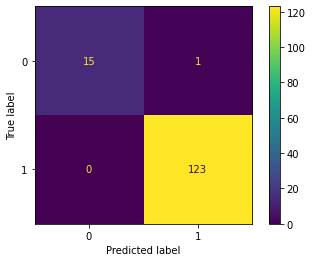

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


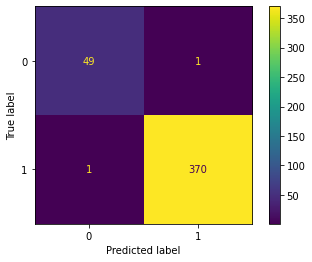

In [22]:
## Encode the labels in 1 hot encoding
from sklearn import svm
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
from sklearn.impute import SimpleImputer


exp_enc = LabelEncoder()
exp_enc.fit(bool_tum_expr)
encoded_Y = exp_enc.transform(bool_tum_expr)
# convert integers to dummy variables (i.e. one hot encoded)

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
exp_data = imp.fit_transform(liver_gene_expr[col_names_exp[2:]])
print(exp_data[1:4,:])

print(np.any(np.isnan(exp_data)))
print(exp_data)
X_train, X_test, y_train, y_test = train_test_split(exp_data, bool_tum_expr, test_size=0.33, random_state=42)

# Run a SVM
# https://scikit-learn.org/stable/modules/svm.html
clf_tumours = svm.SVC(kernel='rbf')
clf_tumours.fit(X_train, y_train)
plot_confusion_matrix(clf_tumours, X_test, y_test)  
plt.show()
plot_confusion_matrix(clf_tumours, exp_data, bool_tum_expr) 

# PCA

Maybe should use SVM instead of PCA + neural network actually!

 

True
(20531, 10)


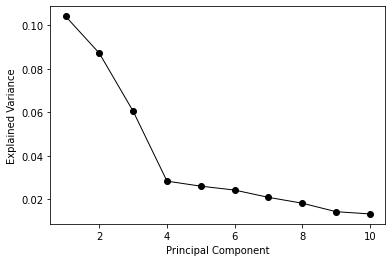

In [21]:
# Using PCA
# turn into PCA
from sklearn.decomposition import PCA
print(liver_gene_expr.isnull().values.any())

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
exp_data = imp.fit_transform(liver_gene_expr[col_names_exp[2:]].T)

#print(liver_gene_expr.apply(pd.isna).all())

#try 10 components or more
exp_pca = PCA(n_components=10)
exp_pc_data = exp_pca.fit_transform(exp_data)

print(exp_pc_data.shape)

PC_values = np.arange(exp_pca.n_components_) + 1
plt.plot(PC_values, exp_pca.explained_variance_ratio_, 'o-', linewidth=1, color='black')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.show()

# 4 Principal Components is almost enough to explain the variance. 


Neural Network with PCA Input

# TensorBoard for Model Evaluation

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
# %reload_ext tensorboard

%tensorboard --logdir /dir/

# or use %tensorboard --logdir /dir/

# JUST reference info below here

# Neural Network


In [11]:
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)
X_train, X_test, y_train, y_test = train_test_split(exp_pc_data, bool_tum_expr, test_size=0.33, random_state=42)
# create model

model = Sequential()
model.add(Dense(2,  activation='sigmoid', input_shape=(3,),  name="bottleneck"))
model.add(Dense(3,  activation='softmax'))

#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, y_train, epochs = 150, batch_size = 4)

ValueError: ignored

In [ ]:
scores = model.evaluate(X_test, y_test)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))